In [116]:
%pip install scipy
%pip install scikit-learn


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid")

# Läs in data – ändra filnamn om det behövs
df = pd.read_csv("dataset.csv", delimiter=";")

print(df.shape)
df.head()


(50000, 19)


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2020-02-11 00:00,"2,020.0000","1,930,438,491.0000",2020-01-26,20200125,20200126,"20,200,210.0000",USD,RV,1.0000,NaN,"54,273.2800","20,200,126.0000",NAH4,"1,930,438,491.0000",0
1,U001,200980828,BEN E,2019-08-08 00:00,"2,019.0000","1,929,646,410.0000",2019-07-22,20190722,20190722,"20,190,811.0000",USD,RV,1.0000,NaN,"79,656.6000","20,190,722.0000",NAD1,"1,929,646,410.0000",0
2,U001,200792734,MDV/ trust,2019-12-30 00:00,"2,019.0000","1,929,873,765.0000",2019-09-14,20190914,20190914,"20,190,929.0000",USD,RV,1.0000,NaN,"2,253.8600","20,190,914.0000",NAA8,"1,929,873,765.0000",0
3,CA02,140105686,SYSC llc,NaN,"2,020.0000","2,960,623,488.0000",2020-03-30,20200330,20200330,"20,200,410.0000",CAD,RV,1.0000,NaN,"3,299.7000","20,200,331.0000",CA10,"2,960,623,488.0000",1
4,U001,200769623,WAL-MAR foundation,2019-11-25 00:00,"2,019.0000","1,930,147,974.0000",2019-11-13,20191113,20191113,"20,191,128.0000",USD,RV,1.0000,NaN,"33,133.2900","20,191,113.0000",NAH4,"1,930,147,974.0000",0


In [118]:
# Hjälpfunktion för datum i formatet ÅÅÅÅMMDD eller ÅÅÅÅMMDD.0
def fix_date(col):
    return (
        col.astype(str)
        .str.replace(".0", "", regex=False)
        .str.zfill(8)
        .pipe(pd.to_datetime, format="%Y%m%d", errors="coerce")
    )

# Kolumner som hade YYYYMMDD
raw_yyyymmdd_cols = [
    "document_create_date",
    "document_create_date.1",
    "due_in_date",
    "baseline_create_date",
]

for col in raw_yyyymmdd_cols:
    if col in df.columns:
        df[col] = fix_date(df[col])

# Kolumner som redan är riktiga datumsträngar
for col in ["posting_date", "clear_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

df[raw_yyyymmdd_cols + ["posting_date", "clear_date"]].head()


,document_create_date,document_create_date.1,due_in_date,baseline_create_date,posting_date,clear_date
0,2020-01-25,2020-01-26,2020-02-10,2020-01-26,2020-01-26,2020-02-11
1,2019-07-22,2019-07-22,2019-08-11,2019-07-22,2019-07-22,2019-08-08
2,2019-09-14,2019-09-14,2019-09-29,2019-09-14,2019-09-14,2019-12-30
3,2020-03-30,2020-03-30,2020-04-10,2020-03-31,2020-03-30,NaT
4,2019-11-13,2019-11-13,2019-11-28,2019-11-13,2019-11-13,2019-11-25


In [ ]:
# Skapa unikt kund-ID om det saknas
# Använder cust_number som källa och factorize för deterministiska id:n
if "customer_alt_id" not in df.columns:
    df["customer_alt_id"], _ = pd.factorize(df["cust_number"])
    df["customer_alt_id"] = df["customer_alt_id"] + 1  # starta på 1 i stället för 0

print(f"Skapade customer_alt_id: {df['customer_alt_id'].nunique()} unika kunder")


In [119]:
# Stängda fakturor (antingen via isOpen eller clear_date)
if "isOpen" in df.columns:
    closed_invoices = df[df["isOpen"] == 0].copy()
else:
    closed_invoices = df[df["clear_date"].notna()].copy()

# Försening i dagar (betalning relativt förfallodatum)
closed_invoices["delay_days"] = (
    (closed_invoices["clear_date"] - closed_invoices["due_in_date"])
    .dt.days
)

def classify_status(delay):
    if pd.isna(delay):
        return "unknown"
    if delay < -1:
        return "early"
    elif -1 <= delay <= 1:
        return "on_time"
    else:
        return "late"

closed_invoices["payment_status"] = closed_invoices["delay_days"].apply(classify_status)
closed_invoices["is_late"]  = (closed_invoices["payment_status"] == "late").astype(int)
closed_invoices["is_early"] = (closed_invoices["payment_status"] == "early").astype(int)

closed_invoices[["delay_days", "payment_status", "is_early", "is_late"]].head()


,delay_days,payment_status,is_early,is_late
0,1,on_time,0,0
1,-3,early,1,0
2,92,late,0,1
4,-3,early,1,0
5,61,late,0,1


In [120]:
# Veckodagar med + 1 så att (1 = måndag, 7 = söndag)
closed_invoices["due_weekday"] = closed_invoices["due_in_date"].dt.weekday + 1
closed_invoices["posting_weekday"] = closed_invoices["posting_date"].dt.weekday + 1


# One-hot för veckodagar (due date)
due_weekday_dummies = pd.get_dummies(
    closed_invoices["due_weekday"],
    prefix="due_wday"
)

# One-hot för veckodagar (posting date)
posting_weekday_dummies = pd.get_dummies(
    closed_invoices["posting_weekday"],
    prefix="post_wday"
)

# Belopp
closed_invoices["amount"] = closed_invoices["total_open_amount"]

# Tidsfrist mellan posting_date och due_in_date
closed_invoices["grace_period"] = (
    (closed_invoices["due_in_date"] - closed_invoices["posting_date"])
    .dt.days
)

closed_invoices[[
    "delay_days", "payment_status", "due_weekday",
    "posting_weekday", "amount", "grace_period"
]].head()


,delay_days,payment_status,due_weekday,posting_weekday,amount,grace_period
0,1,on_time,1,7,"54,273.2800",15
1,-3,early,7,1,"79,656.6000",20
2,92,late,7,6,"2,253.8600",15
4,-3,early,4,3,"33,133.2900",15
5,61,late,5,5,"22,225.8400",14


In [121]:
# Dokumenttyp
if "document type" in closed_invoices.columns:
    document_type_dummies = pd.get_dummies(
        closed_invoices["document type"], prefix="doctype", dummy_na=False
    )
else:
    document_type_dummies = pd.DataFrame(index=closed_invoices.index)

# Payment terms
if "cust_payment_terms" in closed_invoices.columns:
    payment_terms_dummies = pd.get_dummies(
        closed_invoices["cust_payment_terms"], prefix="terms", dummy_na=False
    )
else:
    payment_terms_dummies = pd.DataFrame(index=closed_invoices.index)

# Business code / type
if "business_code" in closed_invoices.columns:
    business_code_dummies = pd.get_dummies(
        closed_invoices["business_code"], prefix="biz", dummy_na=False
    )
else:
    business_code_dummies = pd.DataFrame(index=closed_invoices.index)

document_type_dummies.head()


,doctype_RV,doctype_X2
0,True,False
1,True,False
2,True,False
4,True,False
5,True,False


In [122]:
base_features = closed_invoices[[
    "is_late",
    "is_early",
    "amount",
    "grace_period"
]]


base_features.head()

,is_late,is_early,amount,grace_period
0,0,0,"54,273.2800",15
1,0,1,"79,656.6000",20
2,1,0,"2,253.8600",15
4,0,1,"33,133.2900",15
5,1,0,"22,225.8400",14


In [123]:
feature_df = pd.concat(
    [
        base_features,
        document_type_dummies,
        payment_terms_dummies,
        business_code_dummies,
        due_weekday_dummies,
        posting_weekday_dummies,
    ],
    axis=1
).copy()


feature_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 0 to 49999
Data columns (total 96 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_late       40000 non-null  int64  
 1   is_early      40000 non-null  int64  
 2   amount        40000 non-null  float64
 3   grace_period  40000 non-null  int64  
 4   doctype_RV    40000 non-null  bool   
 5   doctype_X2    40000 non-null  bool   
 6   terms_90M7    40000 non-null  bool   
 7   terms_B052    40000 non-null  bool   
 8   terms_BR12    40000 non-null  bool   
 9   terms_BR56    40000 non-null  bool   
 10  terms_C106    40000 non-null  bool   
 11  terms_CA10    40000 non-null  bool   
 12  terms_CA30    40000 non-null  bool   
 13  terms_CA60    40000 non-null  bool   
 14  terms_CAB1    40000 non-null  bool   
 15  terms_CAX2    40000 non-null  bool   
 16  terms_MC15    40000 non-null  bool   
 17  terms_NA10    40000 non-null  bool   
 18  terms_NA25    40000 non-null  b

In [ ]:
# Fyll ev. saknade värden innan modell
feature_df = feature_df.fillna(0)


In [124]:
corr_matrix = feature_df.corr(numeric_only=True)

corr_with_late = corr_matrix["is_late"].sort_values(ascending=False)
corr_with_early = corr_matrix["is_early"].sort_values(ascending=False)

print("Korrelation (Pearson):")

for feature, value in corr_with_late.items():
    print(f"{feature:30s}  {value:.4f}")

Korrelation (Pearson):
is_late                         1.0000
due_wday_6                      0.2639
biz_CA02                        0.2427
terms_CA10                      0.2416
post_wday_5                     0.2204
terms_NAX2                      0.1799
terms_NAG2                      0.1072
terms_NA10                      0.0681
terms_NAM1                      0.0647
due_wday_7                      0.0557
terms_NAD5                      0.0554
terms_NAVF                      0.0547
biz_U002                        0.0460
biz_U013                        0.0423
terms_NACB                      0.0364
post_wday_6                     0.0340
terms_NAVQ                      0.0287
terms_NAD4                      0.0240
amount                          0.0239
due_wday_5                      0.0229
terms_NA32                      0.0207
terms_CAB1                      0.0202
biz_U005                        0.0193
terms_NAM3                      0.0187
doctype_X2                      0.0187
te

Spearman-korrelation med is_late:


is_late       1.0000
due_wday_6    0.2639
biz_CA02      0.2427
terms_CA10    0.2416
post_wday_5   0.2204
terms_NAX2    0.1799
terms_NAG2    0.1072
terms_NA10    0.0681
terms_NAM1    0.0647
due_wday_7    0.0557
terms_NAD5    0.0554
terms_NAVF    0.0547
biz_U002      0.0460
biz_U013      0.0423
terms_NACB    0.0364
post_wday_6   0.0340
terms_NAVQ    0.0287
amount        0.0243
terms_NAD4    0.0240
due_wday_5    0.0229
Name: is_late, dtype: float64

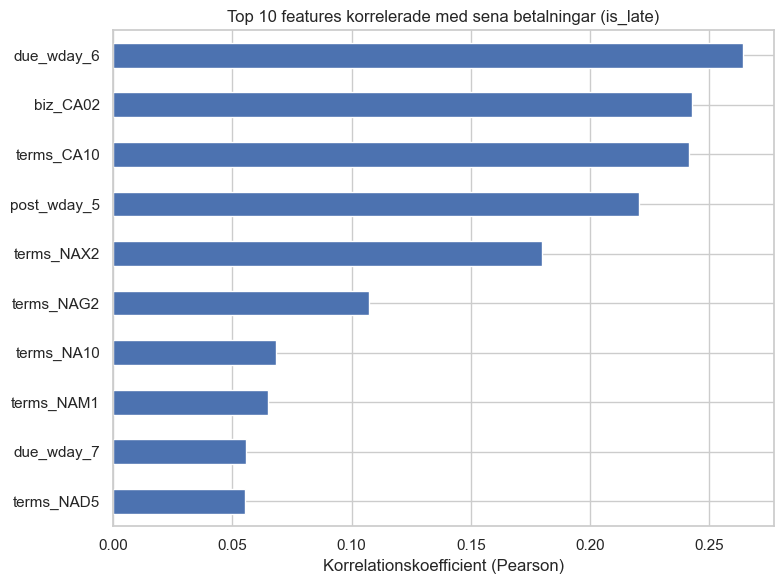

In [125]:
spearman_corr = feature_df.corr(method="spearman", numeric_only=True)
spearman_late = spearman_corr["is_late"].sort_values(ascending=False)

print("Spearman-korrelation med is_late:")
display(spearman_late.head(20))

# Top 10 features (exkl. självkorrelation)
top10_late = corr_with_late.drop(labels=["is_late"]).head(10)

plt.figure(figsize=(8,6))
top10_late.sort_values().plot(kind="barh")
plt.title("Top 10 features korrelerade med sena betalningar (is_late)")
plt.xlabel("Korrelationskoefficient (Pearson)")
plt.tight_layout()
plt.show()


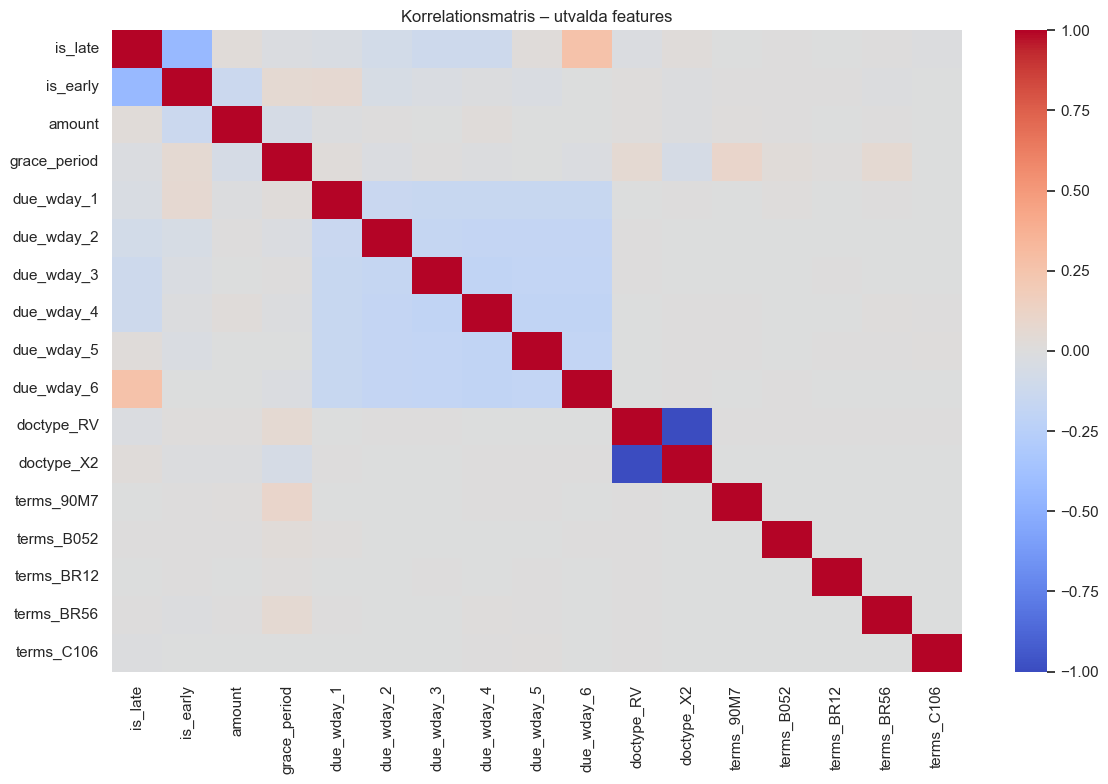

In [126]:
# Basvariabler vi alltid vill ha med
base_cols = [
    "is_late",
    "is_early",
    "amount",
    "grace_period",
]

# Plocka ut några weekday-dummies (t.ex. alla för due & posting)
weekday_cols = [c for c in feature_df.columns if c.startswith("due_wday_") or c.startswith("post_wday_")]

# Begränsa antal för överskådlighet (valfritt)
weekday_cols = weekday_cols[:6]   # ta t.ex. de första 6

# Topp 5 dokumenttyper & payment terms (som tidigare)
doc_cols = list(document_type_dummies.columns[:5])
term_cols = list(payment_terms_dummies.columns[:5])

# Slå ihop alla kolumnnamn och filtrera på de som faktiskt finns i feature_df
cols_for_heatmap = [
    c for c in base_cols + weekday_cols + doc_cols + term_cols
    if c in feature_df.columns
]

corr_subset = feature_df[cols_for_heatmap].corr()

plt.figure(figsize=(max(12, 0.7*len(cols_for_heatmap)), 8))
sns.heatmap(
    corr_subset,
    annot=False,
    cmap="coolwarm",
    center=0
)
plt.title("Korrelationsmatris – utvalda features")
plt.tight_layout()
plt.show()


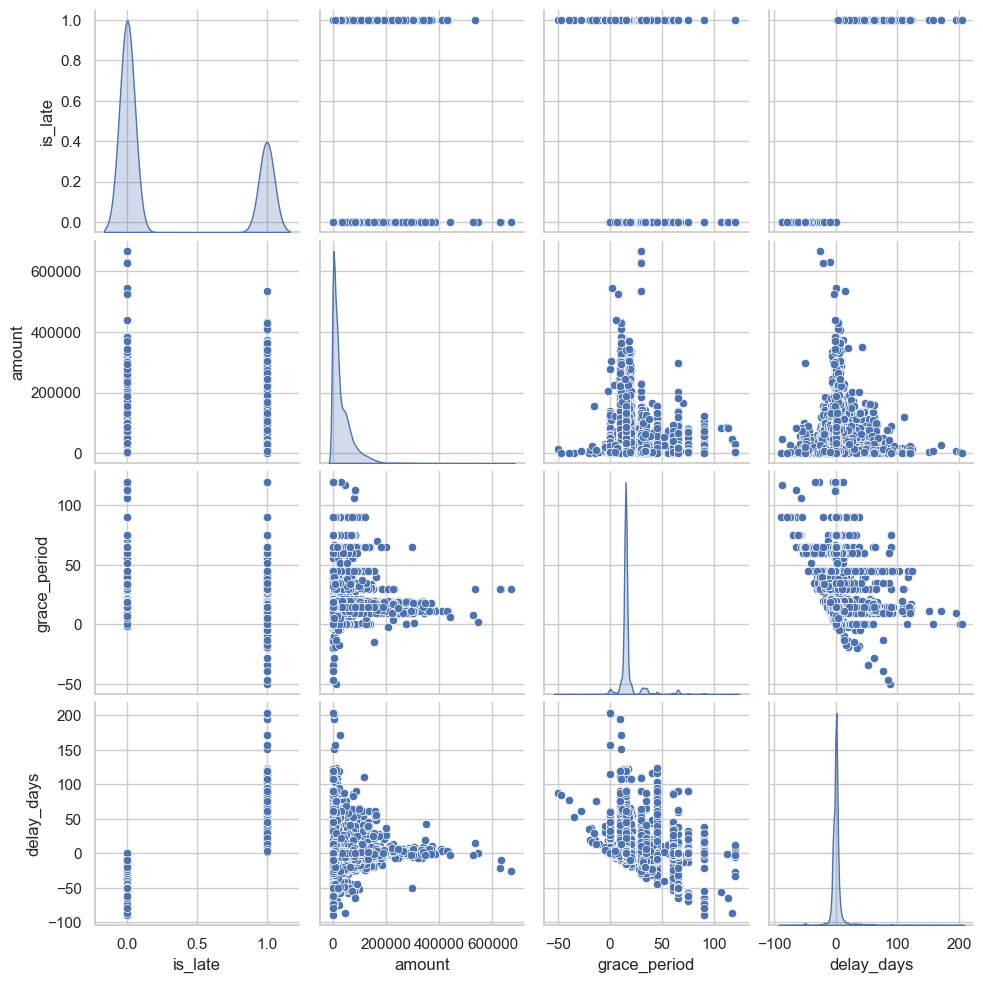

In [127]:
# 2. Correlation Pairplot (endast utvalda features)
# Superkraftfullt för att hitta icke-linjära samband.

sns.pairplot(
    closed_invoices[["is_late", "amount", "grace_period", "delay_days"]],
    diag_kind="kde"
)
plt.show()


In [128]:
# Correlation Table Sorted (Late vs Early)
# Visa bara features som har korrelation > threshold:

threshold = 0.1
corr_tbl = corr_with_late[abs(corr_with_late) > threshold]
corr_tbl


is_late        1.0000
due_wday_6     0.2639
biz_CA02       0.2427
terms_CA10     0.2416
post_wday_5    0.2204
terms_NAX2     0.1799
terms_NAG2     0.1072
terms_NAM4    -0.1095
due_wday_3    -0.1119
due_wday_4    -0.1136
terms_NAH4    -0.1923
biz_U001      -0.2495
is_early      -0.4323
Name: is_late, dtype: float64

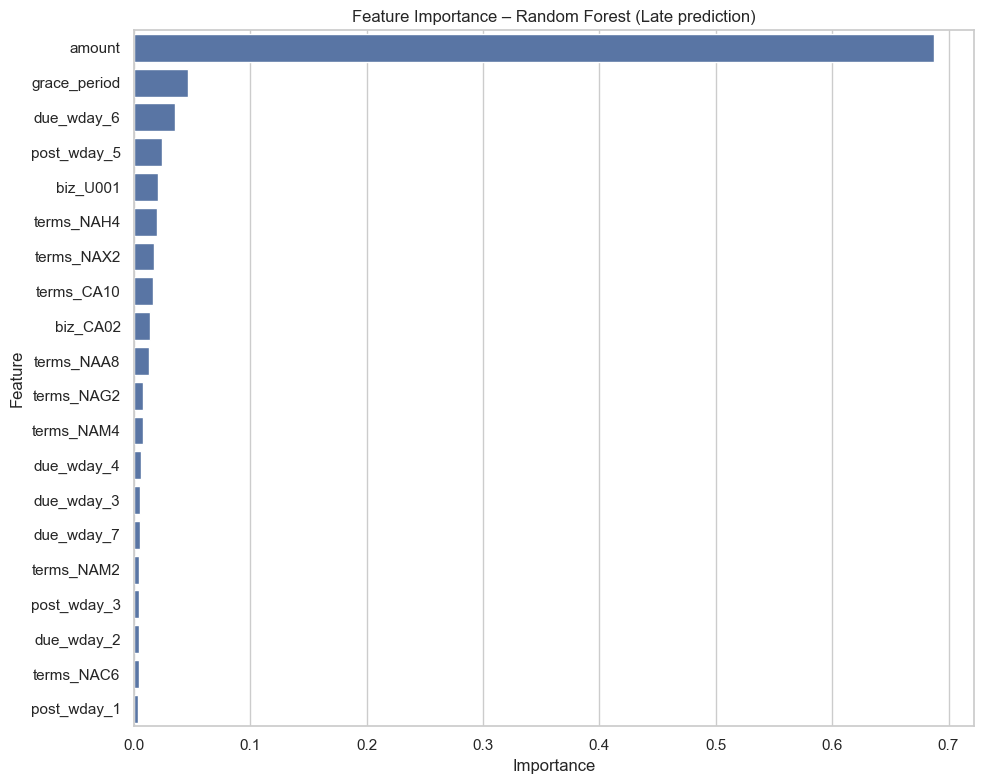

amount         0.6875
grace_period   0.0463
due_wday_6     0.0350
post_wday_5    0.0241
biz_U001       0.0208
terms_NAH4     0.0203
terms_NAX2     0.0174
terms_CA10     0.0162
biz_CA02       0.0141
terms_NAA8     0.0134
terms_NAG2     0.0081
terms_NAM4     0.0079
due_wday_4     0.0060
due_wday_3     0.0057
due_wday_7     0.0053
terms_NAM2     0.0049
post_wday_3    0.0043
due_wday_2     0.0042
terms_NAC6     0.0042
post_wday_1    0.0040
dtype: float64

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Feature matrix & target
X = feature_df.drop(columns=["is_late", "is_early"])
y = feature_df["is_late"]

# 2. Train/test-split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3. Train Random Forest
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 4. Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# 5. Plot top 20 features
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x=top20.values, y=top20.index)
plt.title("Feature Importance – Random Forest (Late prediction)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 6. Visa toppvärden i tabell
top20


=== Modellprestanda ===
Accuracy:        0.7344
Precision:       0.5577
Recall:          0.5439
F1-score:        0.5507
ROC-AUC:         0.7622


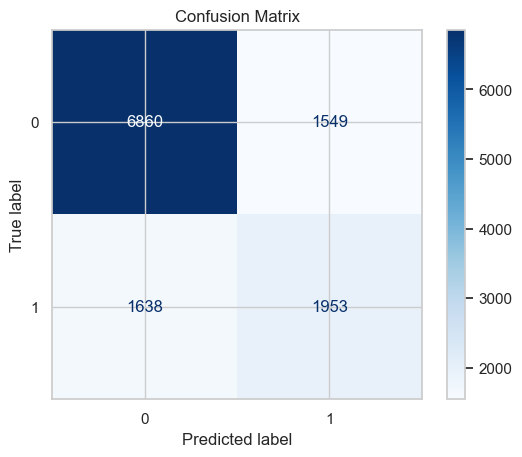

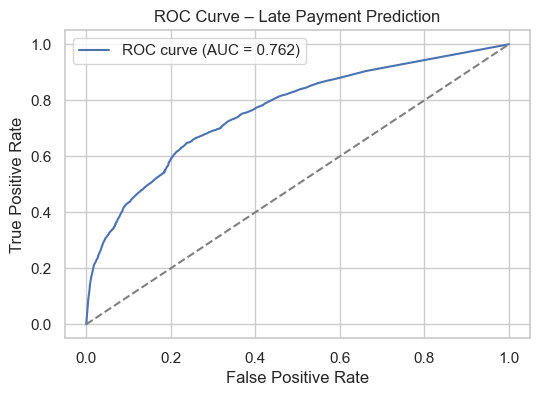

In [130]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# -------------------------------
# 1. Dataset (som du har byggt)
# -------------------------------
X = feature_df.drop(columns=["is_late", "is_early"])
y = feature_df["is_late"]

# -------------------------------
# 2. Train/Test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# 3. Träna modellen
# -------------------------------
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# -------------------------------
# 4. Prediktioner
# -------------------------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# -------------------------------
# 5. Grundläggande mått
# -------------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Modellprestanda ===")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1-score:        {f1:.4f}")
print(f"ROC-AUC:         {auc:.4f}")

# -------------------------------
# 6. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# 7. ROC Curve
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Late Payment Prediction")
plt.legend()
plt.show()


In [131]:
# ROC curve ger fpr, tpr och thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Youden's J-statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"Sensitivity (TPR): {tpr[optimal_idx]:.4f}")
print(f"Specificity (1-FPR): {1 - fpr[optimal_idx]:.4f}")

# Testa modellen med optimal threshold
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

acc_opt = accuracy_score(y_test, y_pred_opt)
prec_opt = precision_score(y_test, y_pred_opt)
rec_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)

print("\n=== Prestanda vid optimal threshold ===")
print(f"Accuracy:  {acc_opt:.4f}")
print(f"Precision: {prec_opt:.4f}")
print(f"Recall:    {rec_opt:.4f}")
print(f"F1-score:  {f1_opt:.4f}")


Optimal threshold (Youden's J): 0.2733
Sensitivity (TPR): 0.6477
Specificity (1-FPR): 0.7620

=== Prestanda vid optimal threshold ===
Accuracy:  0.7278
Precision: 0.5376
Recall:    0.6477
F1-score:  0.5875


In [ ]:
# Säkerställ att customer_alt_id finns även om tidigare celler hoppats över
if "customer_alt_id" not in closed_invoices.columns:
    closed_invoices["customer_alt_id"], _ = pd.factorize(closed_invoices["cust_number"])
    closed_invoices["customer_alt_id"] = closed_invoices["customer_alt_id"] + 1

print(f"customer_alt_id (closed_invoices): {closed_invoices['customer_alt_id'].nunique()} unika")


In [132]:
# Gruppnivå för kunder
customer_stats = (
    closed_invoices
    .groupby("customer_alt_id")
    .agg(
        cust_total_invoices=("invoice_id", "nunique"),
        cust_late_rate=("is_late", "mean"),
        cust_avg_delay=("delay_days", "mean"),
        cust_median_delay=("delay_days", "median"),
        cust_total_amount=("amount", "sum"),
        cust_avg_amount=("amount", "mean"),
        cust_avg_grace_period=("grace_period", "mean"),
    )
    .reset_index()
)

print("Exempel på kundfeatures:")
display(customer_stats.head())


KeyError: 'customer_alt_id'